In [1]:
import psf_calibration_utils as psf_utils
import PIL.Image as Image
import os
import glob

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import scipy.io
import utils.helper_functions as helper
#from diffuser_utils import *
import cv2
# Change this to GPU or CPU depending on your machine
%run fista_spectral_cupy_batch.py GPU

device =  GPU , using GPU and cupy


# Trying Experimental Measurements

In [2]:
if device == 'GPU':
    import cupy as np
    np.cuda.Device(2).use() # Use this to set which GPU to use in cupy
else:
    import numpy as np

In [3]:
# mask
mask_mat = scipy.io.loadmat('../defocuscamdata/calibration_data/spectral_calibration_basler_4_4/cropped_calibration_matrix.mat')
my_mask = np.array(mask_mat['calibration_matrix']) / 255
my_mask.shape, type(my_mask)

((1080, 2000, 66), cupy.core.core.ndarray)

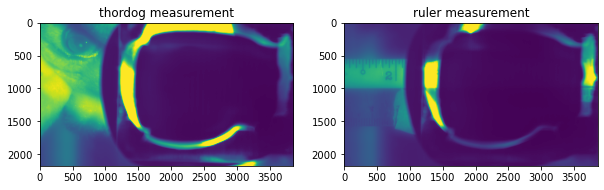

((3, 1080, 2000), cupy.core.core.ndarray)

In [4]:
# measurements (dog and ruler)
ex_meas_dir = "../defocuscamdata/test_measurements/new_camera_measurements_1/"
example_im_dog = np.array(Image.open(os.path.join(ex_meas_dir, "dog/sharp.png")))
example_im_ruler = np.array(Image.open(os.path.join(ex_meas_dir, "ruler/sharp.png")))
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(example_im_dog.get(), vmax = 255)
ax[0].set_title("thordog measurement")
ax[1].imshow(example_im_ruler.get(), vmax = 255)
ax[1].set_title("ruler measurement")
plt.show()


meas_dir = "../defocuscamdata/test_measurements/new_camera_measurements_1/ruler_cropped/"
measurements = ["sharp", "blurry_1", "blurry_2"]
measurement_stack = np.stack([np.array(Image.open(os.path.join(meas_dir,meas +".png"))) for meas in measurements], 0)
measurement_stack = measurement_stack / 255
measurement_stack.shape, type(measurement_stack)
#measurement_stack = measurement_stack[:,90:90+psf_stack.shape[-2],85:85+psf_stack.shape[-1]]

In [5]:
#crop to small enough shape to fit on gpu:
crop_shape = (550, 1200)#(320,460)
resize_shape = (320,460)
shrink_scheme = "crop, resize"

if "crop" in shrink_scheme:
    cr = (250, 570)
    my_mask = my_mask[cr[0]:cr[0]+crop_shape[0], cr[1]:cr[1]+crop_shape[1], :]
    measurement_stack = measurement_stack[:, cr[0]:cr[0]+crop_shape[0], cr[1]:cr[1]+crop_shape[1]]

if "resize" in shrink_scheme:
    my_mask = np.array(cv2.resize(my_mask.get(), dsize=(resize_shape[1], resize_shape[0])))
    measurement_stack = np.transpose(measurement_stack, (1,2,0))
    measurement_stack = np.array(cv2.resize(measurement_stack.get(), dsize=(resize_shape[1], resize_shape[0])))
    measurement_stack = np.transpose(measurement_stack, (2,0,1))

print(my_mask.shape, type(my_mask))
print(measurement_stack.shape, type(measurement_stack))

(320, 460, 66) <class 'cupy.core.core.ndarray'>
(3, 320, 460) <class 'cupy.core.core.ndarray'>


In [6]:
psf_stack = np.stack(np.array(psf_utils.get_psfs_new(scale=True)),0)
psf_stack = psf_utils.center_pad_to_shape(psf_stack, my_mask.shape)
psf_stack.shape, type(psf_stack)
#psf_stack = np.flip(psf_utils.center_pad_to_shape(psfs, mask.shape[:2], val = 0), axis=0)


((3, 320, 460), cupy.core.core.ndarray)

In [7]:
print(np.max(measurement_stack), np.min(measurement_stack))
print(np.max(psf_stack), np.min(psf_stack))
print(np.max(my_mask), np.min(my_mask))

0.5243259803921568 0.16847959292412545
0.9254901960784314 0.0
0.7069185443952972 0.0


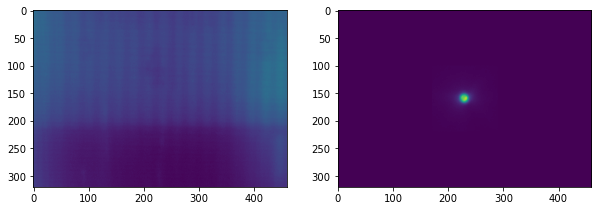

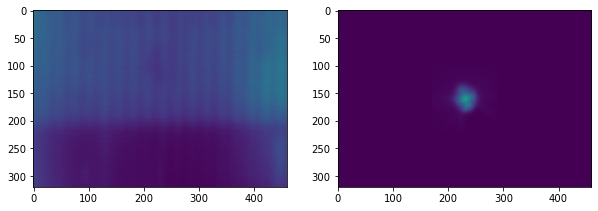

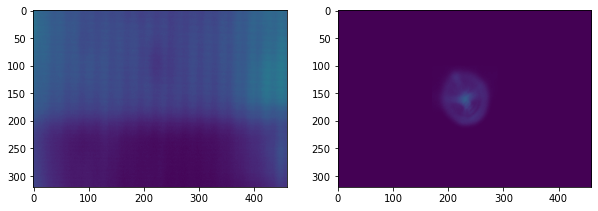

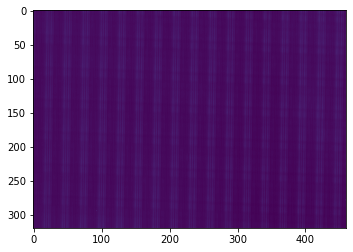

In [8]:
for i in range(measurement_stack.shape[0]):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(measurement_stack[i].get(), vmax = 1)
    ax[1].imshow(psf_stack[i].get(), vmax = 1)
    plt.show()
plt.imshow(np.mean(my_mask, -1).get(), vmax = 1)
plt.show()

In [9]:
fista_comb = fista_spectral_numpy(psf_stack, my_mask)
fista_comb.tv_lambda  = .003
fista_comb.tv_lambdaw = 0.01

In [10]:
out_img = fista_comb.run(measurement_stack)

OutOfMemoryError: Out of memory allocating 332,640,256 bytes (allocated so far: 12,371,040,768 bytes).

# Trying Simulated Images 

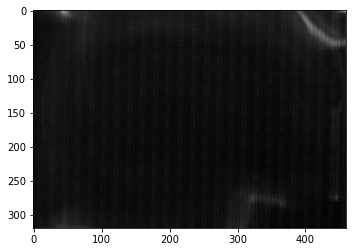

In [14]:
#their mask
loaded_mat = scipy.io.loadmat('../defocuscamdata/sample_data/calibration.mat')
img = plt.imread('../defocuscamdata/sample_data/meas_thordog.png')
mask, _, _ = helper.preprocess(loaded_mat['mask'], loaded_mat['psf'], img)
mask = np.array(mask[:,:,0:-1])

# select mask and condense it
msk_used = my_mask # mask
mask_condensed = (msk_used[...,0::2] + msk_used[...,1::2])[...,0:30]/2
for i in range(0,30):
    mask_condensed[...,i] = mask_condensed[...,i]/np.linalg.norm(mask_condensed[...,i])
mask_condensed = mask_condensed/np.max(mask_condensed)

plt.imshow(np.mean(mask_condensed,-1).get(), cmap = 'gray')
plt.show()

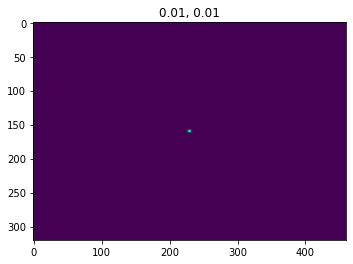

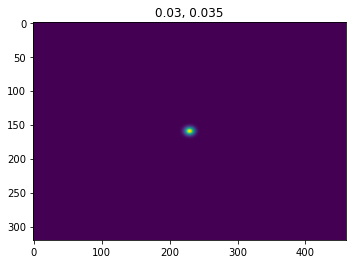

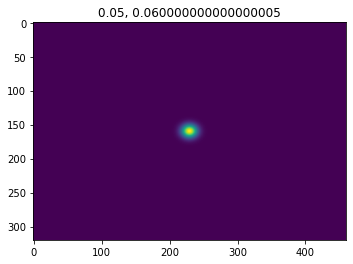

In [80]:
# simulate psf stack
wx, wy, dwx, dwy=0.01, 0.01, 0.02, 0.025
sim_psf_stack = []
for i in range(3):
    wx_i, wy_i = wx+i*dwx, wy+i*dwy
    x=np.linspace(-1,1,psf_stack.shape[2])
    y=np.linspace(-1,1,psf_stack.shape[1])
    X,Y=np.meshgrid(x,y)
    sim_psf= np.exp(-((X/wx_i)**2+(Y/wy_i)**2))
    sim_psf=sim_psf/np.linalg.norm(sim_psf)
    plt.imshow(sim_psf.get())
    plt.title(f"{wx_i}, {wy_i}")
    plt.show()
    sim_psf_stack.append(sim_psf)
sim_psf_stack = np.stack(sim_psf_stack, 0)


In [16]:
sim_psf_stack = psf_stack

py = int((sim_psf_stack.shape[1])//2)    # Pad size
px = int((sim_psf_stack.shape[2])//2)    # Pad size

def pad(x):
    if len(x.shape) == 2: 
        out = np.pad(x, ([py, py], [px,px]), mode = 'constant')
    elif len(x.shape) == 3:
        out = np.pad(x, ([py, py], [px,px], [0, 0]), mode = 'constant')
    return out

def crop(x):
    return x[py:-py, px:-px]

def Hfor(x, psf, mask):
    H = np.expand_dims(np.fft.fft2((np.fft.ifftshift(pad(psf), axes = (0,1))), axes = (0,1)), -1) 
    x = np.fft.ifft2(H* np.fft.fft2(pad(x), axes = (0,1)), axes = (0,1))
    x = np.sum(mask* crop(np.real(x)), 2)
    return x

(1040, 1392, 31)
Resized to: 460 320


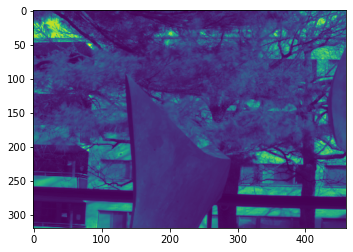

Simulating measurements with increasing levels of blur:


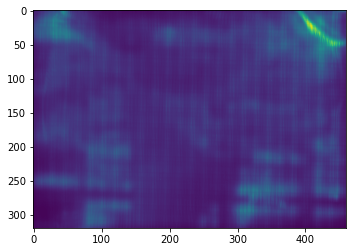

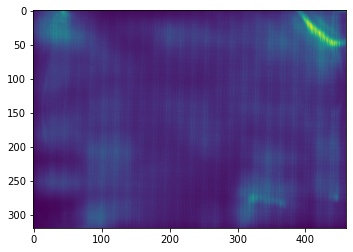

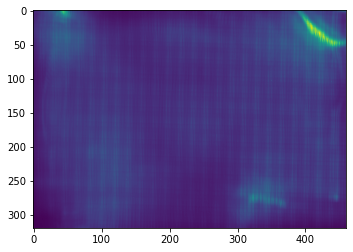

In [17]:
# get ex image
allFiles = glob.glob('/home/kyanny_waller/summerResearch/CZ_hsdb/*.mat')
image = scipy.io.loadmat(allFiles[8])['ref']
print(image.shape)
image = np.array(cv2.resize(image[...,0:30], (sim_psf_stack.shape[2], sim_psf_stack.shape[1])))
print("Resized to:",sim_psf_stack.shape[2],sim_psf_stack.shape[1])
plt.imshow(np.mean(image, -1).get())
plt.show()


#simulate measurmenets
print("Simulating measurements with increasing levels of blur:")
simulated_meas_stack = []
for i in range(sim_psf_stack.shape[0]):
    sim = Hfor(image, sim_psf_stack[i], mask_condensed)
    simulated_meas_stack.append(sim)
    plt.imshow(sim.get())
    plt.show()
simulated_meas_stack = np.stack(simulated_meas_stack, 0)

In [18]:
fista_comb = fista_spectral_numpy(sim_psf_stack, mask_condensed)
fista_comb.tv_lambda = .03
fista_comb.tv_lambdaw = 0.05

iteration:  0  loss:  22113928.70468517


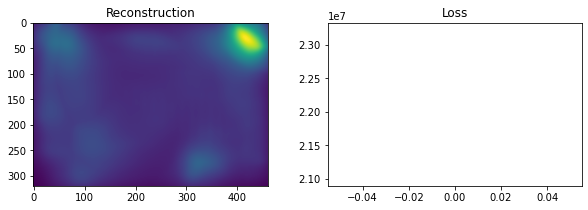

iteration:  20  loss:  43484.518881257674


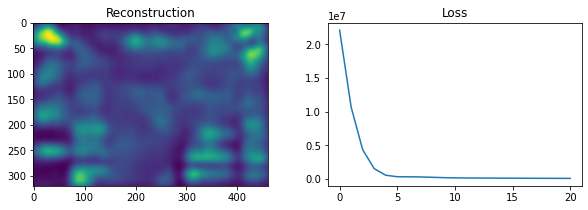

iteration:  40  loss:  12415.966422131887


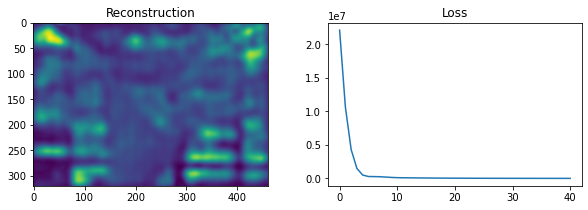

iteration:  60  loss:  5559.049978121403


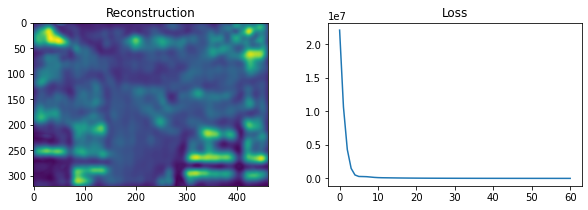

iteration:  80  loss:  3123.5656981303487


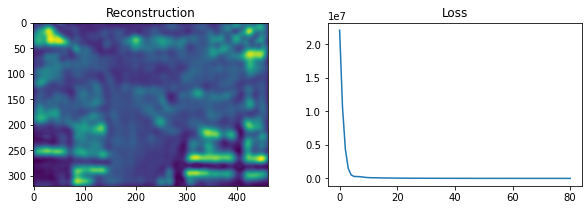

iteration:  100  loss:  1732.0245714473724


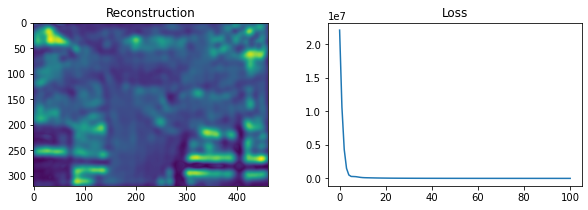

iteration:  120  loss:  1125.7453523650197


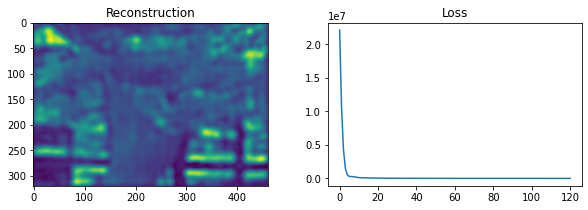

iteration:  140  loss:  804.3196066602042


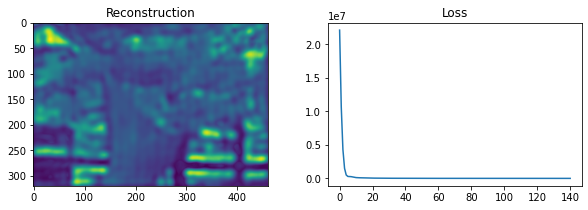

iteration:  160  loss:  562.1116724051898


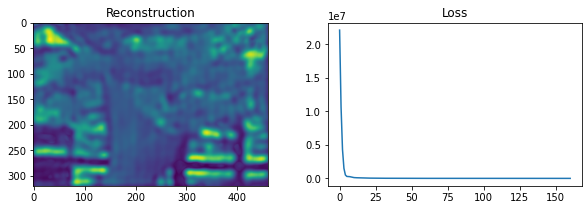

iteration:  180  loss:  446.7636309839752


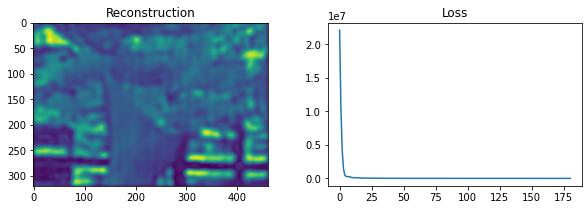

KeyboardInterrupt: 

In [19]:
out_img = fista_comb.run(simulated_meas_stack)